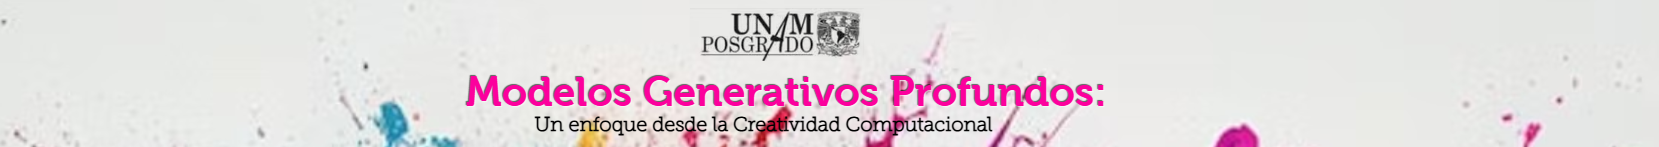

# Autocodificador Determinista vs Variacional - Fashion-MNIST

En este cuaderno exploraremos las similitudes y diferencias entre el autocodificador determinista y el variacional, en el conjunto de datos Fashion MNIST.

In [1]:
import os
from tensorflow import keras
import tensorflow.keras.backend as K
import matplotlib.pyplot as plt
import numpy as np
from matplotlib.patches import Ellipse
import matplotlib.pyplot as plt
import numpy as np

## 1. Cargar ambos modelos ya entrenados

In [2]:
# Cargaremos los modelos desde Google Drive
from google.colab import drive
drive.mount('/content/drive')

import sys
sys.path.append('/content/drive/My Drive/Colab Notebooks/CursoIAGenerativa/')

Mounted at /content/drive


1.1 Cargar los modelos ya entrenados del autocodificador determinista

In [3]:
drive_path = "/content/drive/My Drive/Colab Notebooks/CursoIAGenerativa/notebooks/Clase11_autoencoders_II"

# Modelos del autocodificador determinista
encoder_determinista = keras.models.load_model(os.path.join(drive_path, "encoder_det_fashion.keras"))
decoder_determinista = keras.models.load_model(os.path.join(drive_path, "decoder_det_fashion.keras"))

1.2 Cargar los modelos ya entrenados del autocodificador variacional

In [4]:
# ==============================================================
# NOTA IMPORTANTE:
# En el VAE necesitamos una capa personalizada llamada "Sampling",
# que implementa el truco de reparametrización:
#        z = mean + exp(log_var / 2) * epsilon
#
# Keras no incluye esta capa de forma nativa. Cuando guardamos y
# cargamos un modelo que la usa, Keras solo guarda una referencia
# con el nombre "Sampling", pero no el código de la clase.
#
# Por eso debemos volver a definirla aquí antes de cargar el encoder
# entrenado, para que Keras pueda reconstruir correctamente el modelo.
# ==============================================================
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras import models

class Sampling(layers.Layer):
    def call(self, inputs):
        z_mean, z_log_var = inputs
        batch = tf.shape(z_mean)[0]
        dim = tf.shape(z_mean)[1]
        epsilon = K.random_normal(shape=(batch, dim))
        return z_mean + tf.exp(0.5 * z_log_var) * epsilon



In [6]:
# Modelos del autocodificador variacional
encoder_variacional = keras.models.load_model(
    os.path.join(drive_path, "encoder_vae_fashion.keras"),
    custom_objects={"Sampling": Sampling}
)
decoder_variacional = keras.models.load_model(os.path.join(drive_path, "decoder_vae_fashion.keras"))

## 2. Comparación de sus arquitecturas

In [7]:
# Comparación de los codificadores

print("Codificador Determinista")
encoder_determinista.summary()
print("\n")
print("Codificador Variacional")
encoder_variacional.summary()


Codificador Determinista


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ encoder_input (InputLayer)      │ (None, 32, 32, 1)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d (Conv2D)                 │ (None, 16, 16, 32)     │           320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 8, 8, 64)       │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 4, 4, 128)      │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 2048)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ encoder_output (Dense)          │ (None, 2)              │         4,098 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 96,770 (378.01 KB)

 Trainable params: 96,770 (378.01 KB)

 Non-trainable params: 0 (0.00 B)



Codificador Variacional


Model: "encoder"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ encoder_input       │ (None, 32, 32, 1) │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d (Conv2D)     │ (None, 16, 16,    │        320 │ encoder_input[0]… │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_1 (Conv2D)   │ (None, 8, 8, 64)  │     18,496 │ conv2d[0][0]      │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_2 (Conv2D)   │ (None, 4, 4, 128) │     73,856 │ conv2d_1[0][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ flatten (Flatten)   │ (None, 2048)      │          0 │ conv2d_2[0][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ z_mean (Dense)      │ (None, 2)         │      4,098 │ flatten[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ z_log_var (Dense)   │ (None, 2)         │      4,098 │ flatten[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ sampling (Sampling) │ (None, 2)         │          0 │ z_mean[0][0],     │
│                     │                   │            │ z_log_var[0][0]   │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 100,868 (394.02 KB)

 Trainable params: 100,868 (394.02 KB)

 Non-trainable params: 0 (0.00 B)

In [8]:
# Comparación de los decodificadores

print("Decodificador Determinista")
decoder_determinista.summary()
print("\n")
print("Decodificador Variacional")
decoder_variacional.summary()

Decodificador Determinista


Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ decoder_input (InputLayer)      │ (None, 2)              │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 2048)           │         6,144 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ reshape (Reshape)               │ (None, 4, 4, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_transpose                │ (None, 8, 8, 128)      │       147,584 │
│ (Conv2DTranspose)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_transpose_1              │ (None, 16, 16, 64)     │        73,792 │
│ (Conv2DTranspose)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_transpose_2              │ (None, 32, 32, 32)     │        18,464 │
│ (Conv2DTranspose)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ decoder_output (Conv2D)         │ (None, 32, 32, 1)      │           289 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 246,273 (962.00 KB)

 Trainable params: 246,273 (962.00 KB)

 Non-trainable params: 0 (0.00 B)



Decodificador Variacional


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ decoder_input (InputLayer)      │ (None, 2)              │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 2048)           │         6,144 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ reshape (Reshape)               │ (None, 4, 4, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_transpose                │ (None, 8, 8, 128)      │       147,584 │
│ (Conv2DTranspose)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_transpose_1              │ (None, 16, 16, 64)     │        73,792 │
│ (Conv2DTranspose)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_transpose_2              │ (None, 32, 32, 32)     │        18,464 │
│ (Conv2DTranspose)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ decoder_output (Conv2D)         │ (None, 32, 32, 1)      │           289 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 246,273 (962.00 KB)

 Trainable params: 246,273 (962.00 KB)

 Non-trainable params: 0 (0.00 B)

## 3. Comparación de la calidad de la reconstrucción de imágenes

3.1 Decargar el dataset de Fashion-MNISt y preprocesar las imágenes

In [10]:

# Tomar un batch de imágenes de prueba
(x_train, _), (x_test, _) = keras.datasets.fashion_mnist.load_data()

def preprocess(imgs):
    """
    Normalize and reshape the images
    """
    imgs = imgs.astype("float32") / 255.0
    imgs = np.pad(imgs, ((0, 0), (2, 2), (2, 2)), constant_values=0.0)
    imgs = np.expand_dims(imgs, -1)
    return imgs


x_train = preprocess(x_train)
x_test = preprocess(x_test)



3.2 Pasamos las imágenes por el autoencoder determinista y por el variacional, y visualizamos sus reconstrucciones.

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
z_mean: [[-0.02241594 -1.9358156 ]
 [-0.8434747   0.02858501]
 [-0.77324635  0.06141713]
 [ 0.79894906 -0.02958856]
 [-0.9076263  -0.19913441]
 [-0.32789382  1.3052293 ]
 [-0.51618594 -0.6391997 ]
 [-1.4716696   0.7971882 ]
 [-0.38746396  0.9479113 ]
 [ 0.10632458  1.1019629 ]]
z_log_var: [[-5.4480286 -4.597059 ]
 [-5.3091884 -4.514541 ]
 [-5.4920506 -4.647818 ]
 [-7.0617576 -6.1474524]
 [-5.4458175 -4.746441 ]
 [-4.601722  -3.419964 ]
 [-6.4795127 -5.607388 ]
 [-4.4719863 -3.7771292]
 [-5.1527114 -4.175248 ]
 [-5.5242815 -4.378666 ]]
z:  [[-0.02929202 -1.960697  ]
 [-0.91381234  0.01415576]
 [-0.7789805   0.12656173]
 [ 0.7654034  -0.00886524]
 [-0.9158379  -0.22472015]
 [-0.37104538  1.806416  ]
 [-0.55265105 -0.61806774]
 [-1.4807334   0.83735055]
 [-0.34183887  0.9911861 ]
 [ 0.01376016  1.2657858 ]]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step


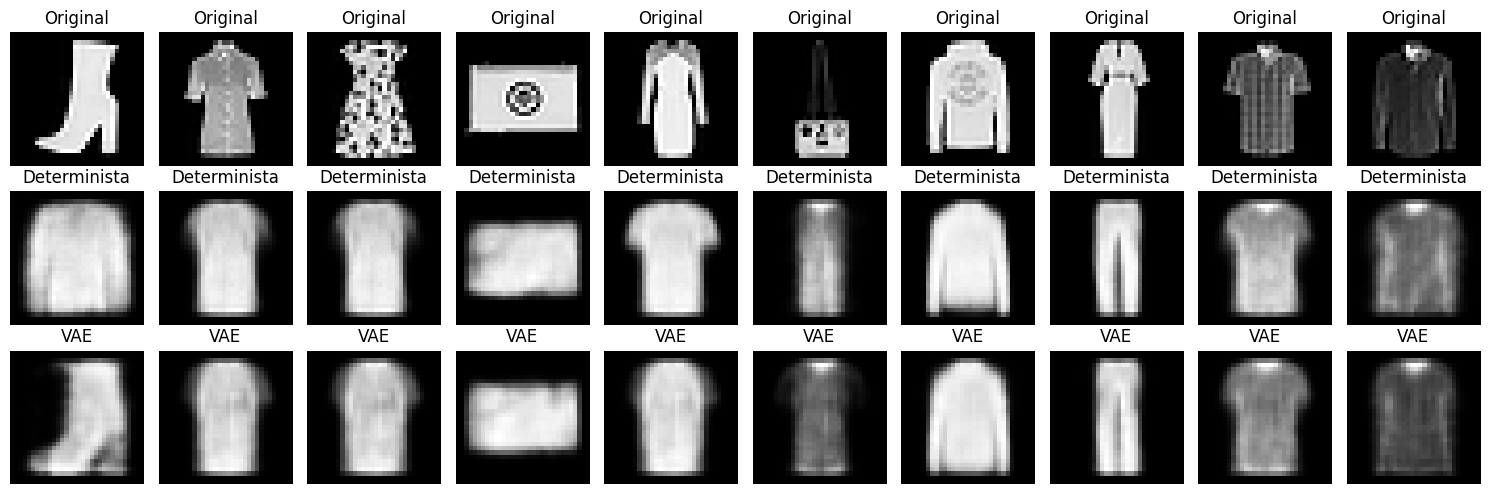

In [14]:
# Seleccionar 10 imágenes al azar
n = 10
idx = np.random.choice(len(x_test), n)
test_images = x_test[idx]

# Reconstrucciones con AE determinista (encoder -> decoder)
z_det = encoder_determinista.predict(test_images)
reconstructions_det = decoder_determinista.predict(z_det)

# Reconstrucciones con VAE (encoder devuelve mean, log_var, z)
z_mean, z_log_var, z = encoder_variacional.predict(test_images)
print("z_mean:", z_mean)
print("z_log_var:", z_log_var)
print("z: ", z)
reconstructions_vae = decoder_variacional.predict(z)

# Graficar resultados
plt.figure(figsize=(15, 5))
for i in range(n):
    # Original
    ax = plt.subplot(3, n, i + 1)
    plt.imshow(test_images[i].squeeze(), cmap="gray")
    plt.title("Original")
    plt.axis("off")

    # Reconstrucción AE
    ax = plt.subplot(3, n, i + 1 + n)
    plt.imshow(reconstructions_det[i].squeeze(), cmap="gray")
    plt.title("Determinista")
    plt.axis("off")

    # Reconstrucción VAE
    ax = plt.subplot(3, n, i + 1 + 2*n)
    plt.imshow(reconstructions_vae[i].squeeze(), cmap="gray")
    plt.title("VAE")
    plt.axis("off")

plt.tight_layout()
plt.show()

# 4. Espacio latente: determinista vs. probabilístico

<h3>4. Espacio latente: determinista vs. probabilístico</h3>

<p>
En este experimento comparamos cómo se representan y reconstruyen las imágenes en el espacio latente usando un
<strong>autoencoder determinista (AE)</strong> frente a un <strong>autoencoder variacional (VAE)</strong>.
</p>

<ul>
  <li>
    <strong>AE determinista:</strong>
    Cada imagen se mapea a un <em>punto fijo</em> en el espacio latente (un vector <code>z</code> único).
    <br>En el gráfico de la izquierda, cada muestra aparece como un punto azul. Las reconstrucciones dependen solo de esa ubicación fija.
  </li>
  <li>
    <strong>VAE:</strong>
    Cada imagen se representa como una <em>distribución normal</em> en el latente, con media <code>&mu;</code> y varianza <code>&sigma;^2</code>.
    El encoder devuelve <code>(&mu;, log&nbsp;&sigma;^2)</code> y, a partir de esos parámetros, se generan múltiples muestras <code>z</code>.
    <br>En el gráfico de la derecha:
    <ul>
      <li><strong>&#10006;</strong> negras: la media <code>&mu;</code> de cada distribución.</li>
      <li><strong>Puntos rojos:</strong> muestras distintas de <code>z</code> (nube probabilística).</li>
      <li><strong>Elipses:</strong> región de alta probabilidad (aquí, ±1σ: ~68.27 % de los datos, ±2σ: ~95.45 % de los datos y ±3σ~99.73 % de los datos;.).</li>
    </ul>
  </li>
</ul>

<p><strong>Objetivo didáctico:</strong></p>
<ul>
  <li>El <strong>AE</strong> produce representaciones puntuales &rarr; suelen generar reconstrucciones más nítidas pero con reestricciones:
  <ul>
  <li>
    <strong>Espacio no regularizado:</strong>
    <ul>
      <li>
        El AE nunca fue entrenado para que su espacio latente siga una distribución conocida
        (como la Normal).
      </li>
      <li>
        Si muestreás vectores aleatorios en el espacio latente, la mayoría no corresponden a regiones “válidas” &rarr; las imágenes resultan no reconocibles o ruido.
      </li>
    </ul>
  </li>
  <li>
    <strong>Continuidad débil:</strong>
    <ul>
      <li>
        En el AE, las interpolaciones entre puntos latentes a veces pasan por regiones del espacio que no contienen ejemplos reales.
      </li>
      <li>
        Eso produce imágenes borrosas o sin forma.
      </li>
    </ul>
  </li>
  <li>
    <strong>Capacidad de muestreo limitada:</strong>
    <ul>
      <li>
        El AE solo “genera” bien si partes de un <em>z</em> que proviene del encoder de un dato real.
      </li>
      <li>
        No sirve para muestreo libre como el VAE.
      </li>
    </ul>
  </li>
</ul>
  </li>
  <li>El <strong>VAE</strong> produce representaciones distribucionales &rarr; reconstrucciones más borrosas, pero con un espacio latente <em>continuo y con mejores propiedades generativas</em>.</li>
</ul>

<p>
Al final también se muestran reconstrucciones:
</p>
<ol>
  <li>Imagen original.</li>
  <li>Reconstrucción del AE.</li>
  <li>Reconstrucción del VAE (usando la media <code>&mu;</code>).</li>
  <li>Reconstrucciones del VAE desde varias muestras de <code>z</code> (debajo de cada imagen se muestra el vector <code>z</code> usado).</li>
</ol>

<p>
Esto permite visualizar cómo el AE “ancla” cada imagen en un único punto, mientras que el VAE permite explorar variaciones alrededor de la misma.
</p>


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 75ms/step


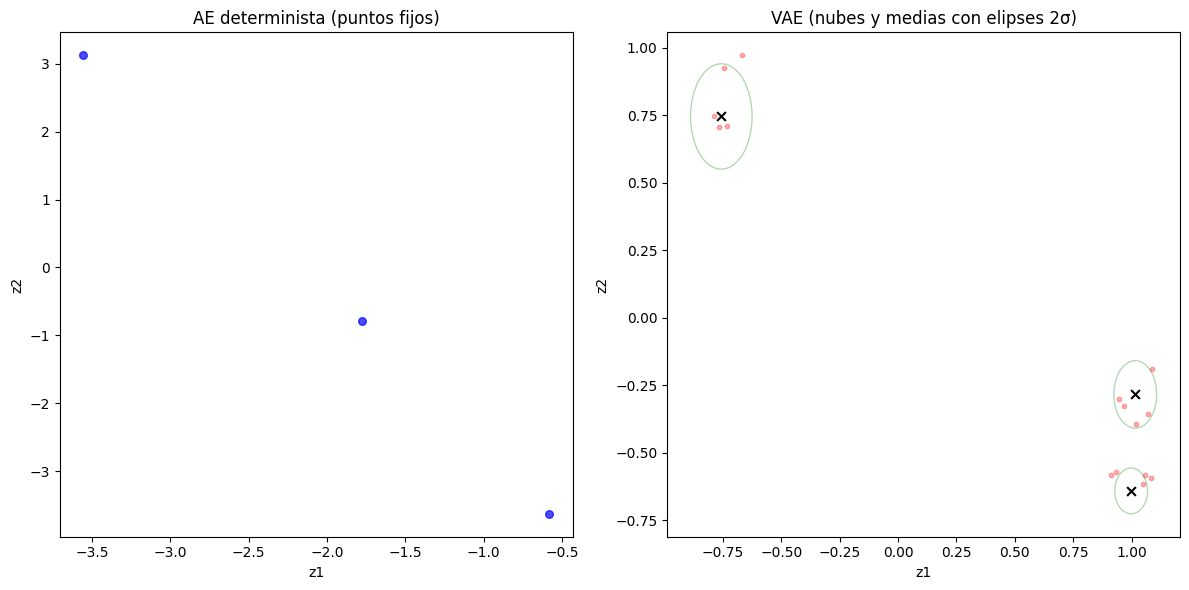

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 86ms/step


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 86ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step


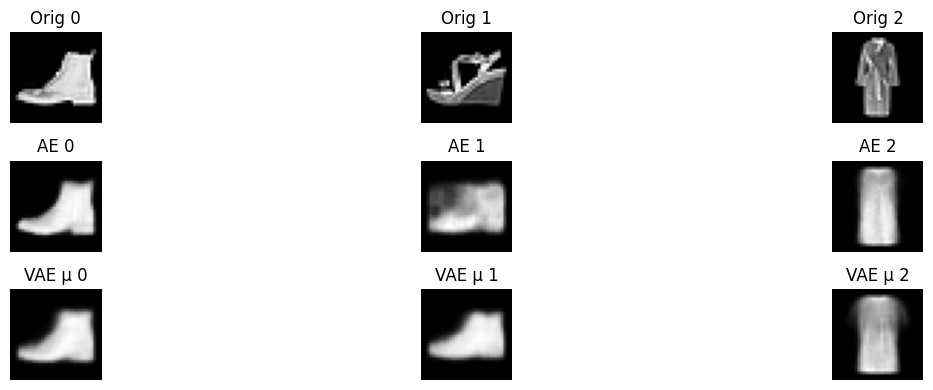

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step


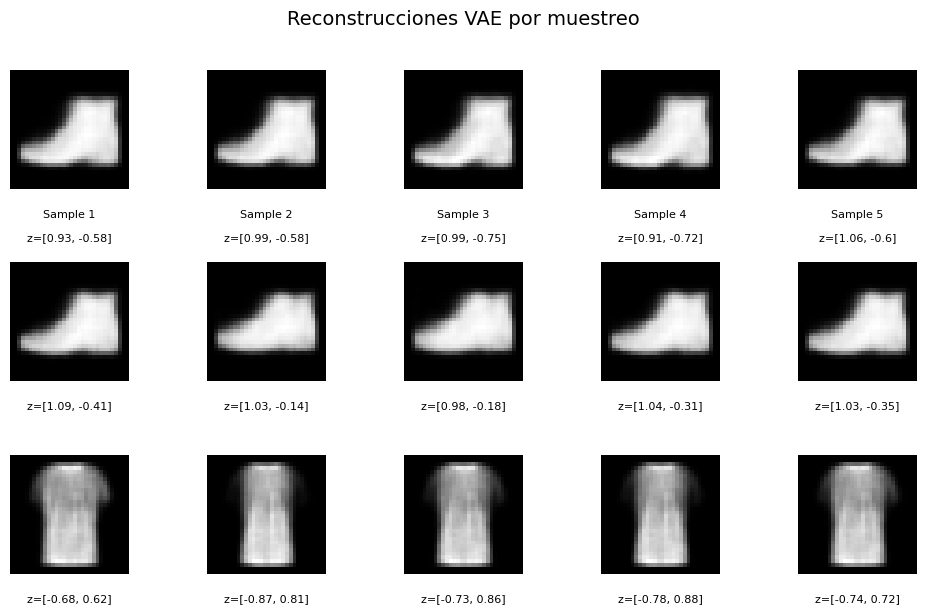

In [15]:
# ============================
# Seleccionar un subconjunto de imágenes
# ============================
n = 3  # número de imágenes a graficar
num_samples = 5  # número de muestras por imagen en el VAE
idx = np.random.choice(len(x_test), n, replace=False)  # índices aleatorios
test_subset = x_test[idx]

# ============================
# AE determinista
# ============================
z_det = encoder_determinista.predict(test_subset)

# ============================
# VAE
# ============================
z_mean, z_log_var, _ = encoder_variacional.predict(test_subset)

# Muestrear varias veces para ver la nube
z_samples = []
labels = []
for i in range(n):
    mean = z_mean[i]
    log_var = z_log_var[i]
    for _ in range(num_samples):
        epsilon = np.random.normal(size=mean.shape)
        z_sample = mean + np.exp(0.5 * log_var) * epsilon
        z_samples.append(z_sample)
        labels.append(i)
z_samples = np.array(z_samples)

# ============================
# Función para dibujar elipses de varianza
# ============================
def draw_ellipse(mean, log_var, ax, color="green", alpha=0.3):
    var = np.exp(log_var)
    width, height = 3 * np.sqrt(var)  # 3σ
    ellipse = Ellipse(
        xy=mean, width=width, height=height,
        edgecolor=color, facecolor="none", lw=1, alpha=alpha
    )
    ax.add_patch(ellipse)

# ============================
# Visualización de espacios latentes
# ============================
plt.figure(figsize=(12, 6))

# AE determinista
ax1 = plt.subplot(1, 2, 1)
ax1.scatter(z_det[:, 0], z_det[:, 1], alpha=0.7, s=30, color="blue")
ax1.set_title("AE determinista (puntos fijos)")
ax1.set_xlabel("z1")
ax1.set_ylabel("z2")

# VAE
ax2 = plt.subplot(1, 2, 2)
ax2.scatter(z_samples[:, 0], z_samples[:, 1], alpha=0.3, s=10, color="red")
ax2.scatter(z_mean[:, 0], z_mean[:, 1], alpha=1.0, s=40, color="black", marker="x")
for i in range(n):
    draw_ellipse(z_mean[i], z_log_var[i], ax2)
ax2.set_title("VAE (nubes y medias con elipses 2σ)")
ax2.set_xlabel("z1")
ax2.set_ylabel("z2")

plt.tight_layout()
plt.show()

# ============================
# Reconstrucciones: Original, AE, VAE (media)
# ============================
z_det = encoder_determinista.predict(test_subset)
reconstructions_det = decoder_determinista.predict(z_det)

plt.figure(figsize=(15, 4))
for i in range(n):
    # Original
    ax = plt.subplot(3, n, i + 1)
    plt.imshow(test_subset[i].squeeze(), cmap="gray")
    plt.title(f"Orig {i}")
    plt.axis("off")

    # Reconstrucción AE
    ax = plt.subplot(3, n, i + 1 + n)
    plt.imshow(reconstructions_det[i].squeeze(), cmap="gray")
    plt.title(f"AE {i}")
    plt.axis("off")

    # Reconstrucción VAE (usando la media)
    z = z_mean[i]
    recon_mean = decoder_variacional.predict(np.expand_dims(z, axis=0))
    ax = plt.subplot(3, n, i + 1 + 2*n)
    plt.imshow(recon_mean[0].squeeze(), cmap="gray")
    plt.title(f"VAE μ {i}")
    plt.axis("off")

plt.tight_layout()
plt.show()

# ============================
# Reconstrucciones VAE por muestreo con valores de z
# ============================
plt.figure(figsize=(num_samples * 2, n * 2))

count = 1
for i in range(n):
    mean = z_mean[i]
    log_var = z_log_var[i]
    for s in range(num_samples):
        epsilon = np.random.normal(size=mean.shape)
        z_sample = mean + np.exp(0.5 * log_var) * epsilon
        recon = decoder_variacional.predict(np.expand_dims(z_sample, axis=0))

        ax = plt.subplot(n, num_samples, count)
        plt.imshow(recon[0].squeeze(), cmap="gray")
        plt.axis("off")

        # Mostrar valores de z como título desplazado hacia abajo
        z_text = np.round(z_sample, 2)
        ax.set_title(f"z={z_text.tolist()}", fontsize=8, y=-0.3)

        if i == 0:
            ax.set_title(f"Sample {s+1}\n\nz={z_text.tolist()}", fontsize=8, y=-0.5)

        count += 1

plt.suptitle("Reconstrucciones VAE por muestreo", fontsize=14, y=1.02)
plt.tight_layout()
plt.show()


# 5. Muestreo libre del espacio latente

<p>
En este experimento vamos a generar imágenes directamente a partir de puntos <code>z</code> muestreados al azar de una
distribución normal estándar <em>N(0, I)</em>.
</p>

<ul>
  <li>
    <strong>AE determinista:</strong>  
    El decoder puede recibir vectores <code>z</code> aleatorios y producir imágenes.  
    Sin embargo, como el espacio latente <em>no está regularizado</em>, muchos de estos puntos no corresponden a regiones "válidas".  
    El resultado suelen ser imágenes distorsionadas o sin sentido.
  </li>
  <li>
    <strong>VAE:</strong>  
    El espacio latente está regularizado para aproximar una distribución normal estándar.  
    Por ello, al muestrear de <em>N(0, I)</em> y decodificar, se generan imágenes plausibles y coherentes con las clases de Fashion-MNIST.  
    Esto es lo que hace al VAE un modelo <em>realmente generativo</em>.
  </li>
</ul>

<p><strong>Visualización:</strong></p>
<ul>
  <li>El primer gráfico muestra los puntos muestreados en el espacio latente (en 2D para simplificar la interpretación).</li>
  <li>Después se presentan las imágenes generadas:
    <ul>
      <li>Fila superior: salidas del decoder del AE determinista.</li>
      <li>Fila inferior: salidas del decoder del VAE.</li>
    </ul>
  </li>
</ul>

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step


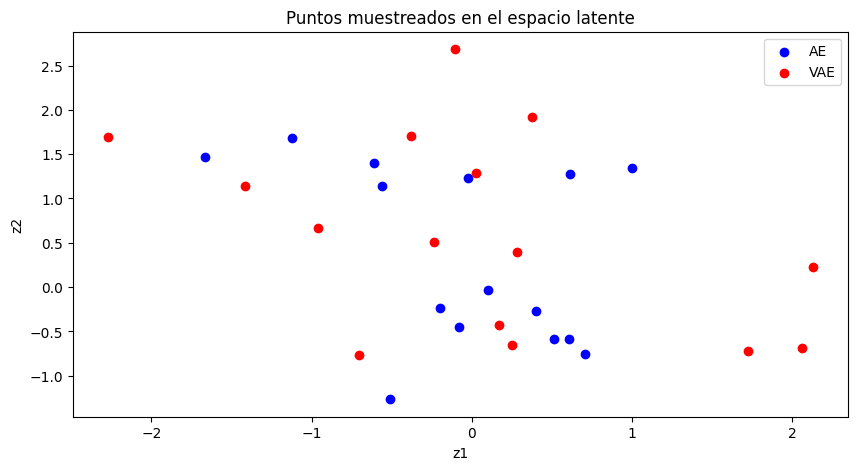

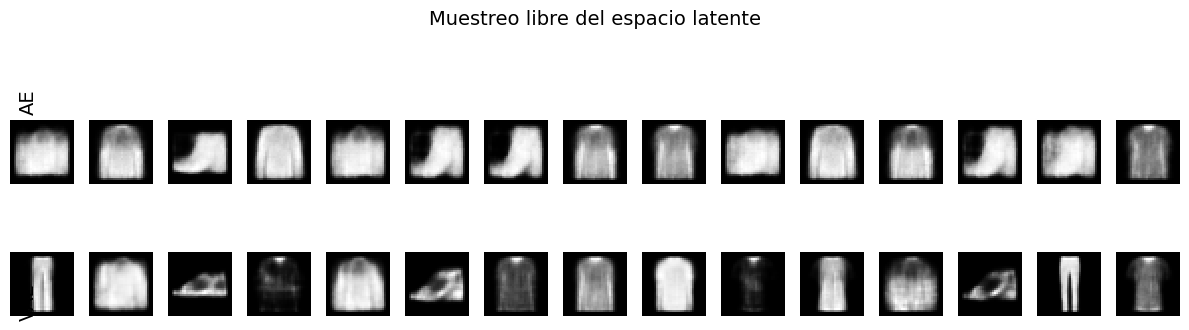

In [16]:
num_samples = 15  # cuántas imágenes generar
latent_dim = z_mean.shape[1]  # dimensión del espacio latente

# ---- AE determinista ----
z_random_ae = np.random.normal(size=(num_samples, latent_dim))
reconstructions_ae = decoder_determinista.predict(z_random_ae)

# ---- VAE ----
z_random_vae = np.random.normal(size=(num_samples, latent_dim))
reconstructions_vae = decoder_variacional.predict(z_random_vae)

# ============================
# Visualización del espacio latente
# ============================
plt.figure(figsize=(10, 5))

# Gráfico 2D
plt.scatter(z_random_ae[:, 0], z_random_ae[:, 1], c="blue", label="AE")
plt.scatter(z_random_vae[:, 0], z_random_vae[:, 1], c="red", label="VAE")
plt.xlabel("z1")
plt.ylabel("z2")
plt.title("Puntos muestreados en el espacio latente")
plt.legend()

plt.show()

# ============================
# Visualización de las imágenes generadas
# ============================
fig = plt.figure(figsize=(12, 4))

# AE
for i in range(num_samples):
    ax = plt.subplot(2, num_samples, i + 1)
    plt.imshow(reconstructions_ae[i].squeeze(), cmap="gray")
    plt.axis("off")

# VAE
for i in range(num_samples):
    ax = plt.subplot(2, num_samples, num_samples + i + 1)
    plt.imshow(reconstructions_vae[i].squeeze(), cmap="gray")
    plt.axis("off")

# Etiquetas de fila al margen
fig.text(0.02, 0.75, "AE", fontsize=14, va="center", rotation=90)
fig.text(0.02, 0.25, "VAE", fontsize=14, va="center", rotation=90)

plt.suptitle("Muestreo libre del espacio latente", fontsize=14)
plt.tight_layout()
plt.show()



# 6. Distribución de las variables latentes en el VAE

En un autoencoder variacional (VAE), cada dimensión del espacio latente está regularizada para aproximar una distribución normal estándar 𝑁(0,1).
Esto se logra gracias al término de divergencia KL en la función de pérdida, que empuja las distribuciones de cada
𝑧i hacia la gaussiana estándar.

En esta celda:

*   Tomaremos un subconjunto de imágenes de prueba.
*   Las codificaremos con el encoder del VAE para obtener sus representaciones latentes 𝑧.
*   Para cada dimensión del latente, graficaremos un histograma de los valores y lo compararemos con la curva de la distribución normal estándar.

32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step


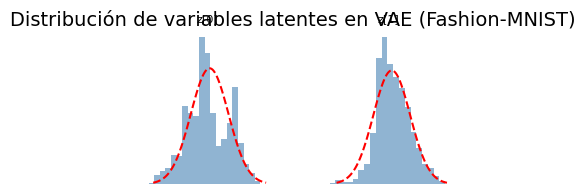

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
from scipy.stats import norm

# Tomar un subconjunto de imágenes de prueba
n_samples = 1000
example_images = x_test[:n_samples]

# Pasarlas por el encoder del VAE
z_mean, z_log_var, z = encoder_variacional.predict(example_images)

# Rango para graficar la gaussiana estándar
x = np.linspace(-3, 3, 100)

latent_dim = z.shape[1]  # número de dimensiones del espacio latente

# Ajustar filas y columnas para graficar todas las dimensiones
cols = min(latent_dim, 10)
rows = int(np.ceil(latent_dim / cols))

fig = plt.figure(figsize=(2*cols, 2*rows))
fig.subplots_adjust(hspace=0.6, wspace=0.4)

for i in range(latent_dim):
    ax = fig.add_subplot(rows, cols, i + 1)
    ax.hist(z[:, i], density=True, bins=20, alpha=0.6, color="steelblue")
    ax.plot(x, norm.pdf(x), "r--")  # Normal estándar
    ax.set_title(f"z[{i}]", fontsize=8)
    ax.axis("off")

plt.suptitle("Distribución de variables latentes en VAE (Fashion-MNIST)", fontsize=14)
plt.show()
